In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=5)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.41.2
Using datasets v2.20.0
Using accelerate v0.31.0
Using sentencepiece v0.1.99
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


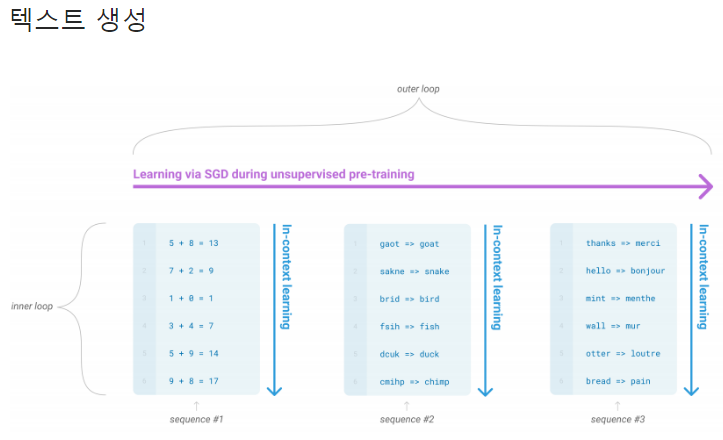


자기 회귀 모델(Autoregressive model) 또는 코잘 언어 모델(causal language model)은 입력 문맥시퀀스  
$x=x_1,x_2,\ldots,x_k$ 이 주어지면 텍스트에 등장하는 토큰 시퀀스     
$y=y_1,y_2,\ldots,y_t$의 확률 $P(y|x)$를 추정하도록 학습함.    
&nbsp;  
일반적으로 충분한 데이터를 얻기 힘들어서 확률의 체인 룰을 사용해 조건부 확률의 곱으로 표현   
$P(y_1, \ldots ,y_t  | x)= \Pi^N_{t+1}P(y_t|y_{<t},x)$               
조건부 확률을 생각하면 의미가 보임, 문장의 이전 단어가 주어지면 다음 단어를 예측함     

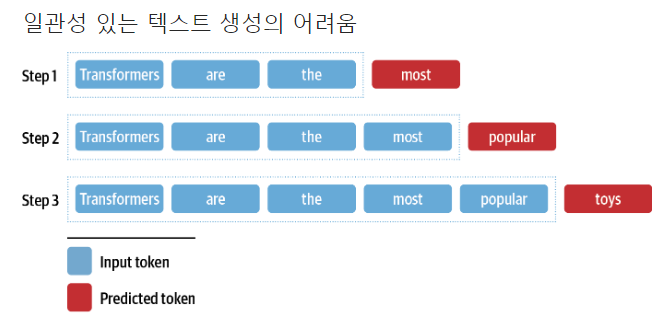

생각해보면 앞 장에서 사용한 BERT와 입력에서 차이가 생김  
BERT의 경우 입력의 시퀀스가 미래 과거 상관없이 한번에 들어가서 한번에 출력으로 나옴  
하지만 GPT는 과거의 데이터만 들어가서 미래의 데이터를 예측하는 모델로 많이 사용함  
이 과정을 특수한 시퀀스 종료 토큰이나 사전에 정의한 최대 길이에 도달할 때까지 반복  
&nbsp;  
이 과정의 핵심은 각 T에서 어떤 토큰을 선택할지 결정하는 디코딩 방법  
언어 모델의 헤드는 각 스텝에서어휘사전에있는 토큰마다 로짓 z를 생성하므로  
소프트 맥스를 적용해 확률 분포로 만들어줌  
$P(y_t=w_i|y_{<t},x)=\text{softmax}(z_{t,i})$  
$\hat{y}=\text{argmax}_y \ P(y|x)$  
$\hat{y}$을 직접 찾으려면 모든 시퀀스를 평가해야하는데 시간이 당연히 오래걸림  
그래서 근사적인 방법을 사용함  

#그리드 서치 디코딩  
단순하게 $\hat{y}=\text{argmax}_y \ P(y|x)$를 그대로 사용 그냥 DQN 개념이랑 똑같음  
각 스텝마다 모델의 출력의 최대 확률을 결정론적으로 선택해버림

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
model_name = "gpt2-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용합니다.
        next_token_logits = output.logits[0, -1, :] # 출력 모아줌
        next_token_probs = torch.softmax(next_token_logits, dim=-1) #소프트 맥스 적용
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True) #소프트 맥스 값이 큰 순서대로 정렬
        # 가장 높은 확률의 토큰을 저장합니다.
        for choice_idx in range(choices_per_step): #5개의 샘플을 선택함
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # 예측한 다음 토큰을 입력에 추가합니다.
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (11.78%),best (6.66%),only (5.62%),first (2.91%),ultimate (2.23%)
1,Transformers are the most,popular (22.63%),successful (5.55%),famous (3.38%),powerful (3.14%),important (2.54%)
2,Transformers are the most popular,toys (8.87%),toy (7.88%),of (5.03%),Transformers (4.69%),franchise (3.88%)
3,Transformers are the most popular toys,of (31.69%),in (23.73%),ever (4.85%),", (4.50%)",for (3.58%)
4,Transformers are the most popular toys of,all (57.47%),the (21.31%),2015 (2.34%),their (1.66%),2014 (1.54%)
5,Transformers are the most popular toys of all,time (94.71%),- (1.86%),. (0.66%),", (0.56%)",times (0.52%)
6,Transformers are the most popular toys of all ...,. (34.98%),", (33.86%)",and (7.03%),! (2.16%),in (1.73%)
7,Transformers are the most popular toys of all ...,They (10.93%),\n (9.23%),The (6.63%),In (2.91%),And (2.68%)


In [4]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False) #여기서 generate 함수가 위에 for 루프역할을 해줌 !!!중요함!!!
print(tokenizer.decode(output[0]))

Transformers are the most popular toys of all time. They


In [5]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home


그리드 서치 알고리즘의 단점이 확실히 나옴   
똑같은 문장이 계속 반복됨 이로 인해 최적의 솔루션으로 이 알고리즘 사용하기는 어려움  
그냥 구현이 간단한 기본 알고리즘  
대신 정확한 출력이 필요한 수식등의 짧은 문장 생성에는 유용하게 쓰임

#빔 서치 디코딩  

$\hat{y}=\text{argmax}_y \ P(y|x)$ 식은 비슷함 대신 1개가 아니라 확률이 높은 b개 만큼 골라줌  
여기서 b를 빔 또는 불완전 가설의 개수를 의미  
하지만 기존 식에서 로그 확률을 사용해서 점수를 매김, 점수라는게 P를 의미하는 듯  
$P(y_1, \ldots ,y_t  | x)= \Pi^N_{t+1}P(y_t|y_{<t},x)$ 원본  
$\log P(y_1, \ldots ,y_t  | x)= \Sigma^N_{t+1}\log P(y_t|y_{<t},x)$ 빔 서치 디코딩  
단순하게 $\Pi$ 가 $\Sigma$로 바뀐건 로그니까 곱하기가 더하기로 바뀜


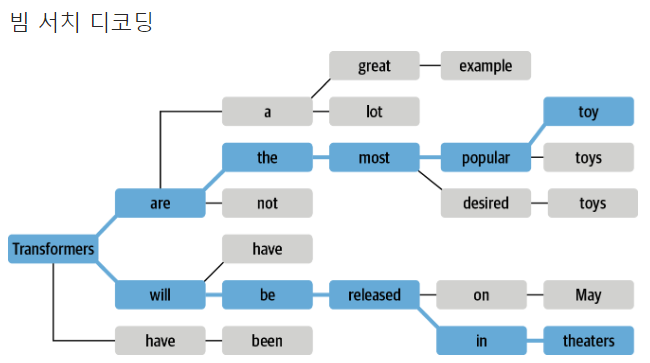

b가 2일때 상황을 이미지로 표현  
각 스텝마다 2개의 출력을 선택함  
근데 왜 로그 확률을 사용하냐? 각 스텝마다 확률은 결국 [0,1]인데 계속 곱하면 수가 계속 작아져버림   
밑에는 책에서 설명한 토큰이 1024개 일 때 상황

In [6]:
0.5 ** 1024

5.562684646268003e-309

이런 상황을 언더플로라고 정의함, 하지만 여기에 로그를 씌우면 값이 커져버림

In [7]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

이런 값이 다루기 쉽고 이 방식은 작은 수에도 적용됨 상대적인 확률을 비교하니까 값만 있으면 돼  

In [8]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [9]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:]) #labels 1:은 모델이 첫번째 입력으로 두번째 출력을 예측하기 때문에 첫번째 레이블은 쓸모가 없음

            # output.logitx :-1은 마지막 로짓에 대한 정답이 없으므로 빼버림 내가 이해한 거로는 마지막 home 을 입력으로 나온 출력이 필요 없어서 버린다는 것으로 이해함
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [10]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

로그 확률: -86.50


In [11]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, #num_beams 를 설정하면 빔 서치로 작동함, 속도가 확실히 느림 b가 커질수록 느려진다고함 성능은 올라가고
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the University of California, Santa Cruz, and
published in the Journal of Mammalogy.


The team, led by Dr. David Hone of the University of California, Santa Cruz,
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.




로그 확률: -65.20


하지만 같은 단어 생성하는건 똑같음 그래서 나온게 n-gram 패널티  
n-그램을 추적해 이전에 보았던 단어를 생성했었으면 그 토큰을 0으롬 만들어 버림  
그럼 이걸 그리디에 쓰면 안돼??

In [12]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)# 여기에 n-gram 패널티 적용
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the National Geographic Society. The team was led by
Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of
the world, but this is the first time we've been able

로그 확률: -79.02


In [13]:
output_beam = model.generate(input_ids, max_length=max_length,do_sample=False, no_repeat_ngram_size=2)# 여기에 n-gram 패널티 적용
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorn herd in an area of Peru known as the "Valley
of Tears." The valley is located in Peru's Andean highlands, and is home to a
number of rare and endangered species.

"We were surprised to find that there were unicorn herds in this remote valley,"

로그 확률: -117.29


그리디에 적용해봤는데 로그 확률이 더 나쁘게 나오긴 함 괜히 빔 서치 쓰는게 아니겠지  
보통 n-그램+빔 서치는 사실적인 정확성을 요하는 요약, 기계 번역 같은곳에서 사용함  
또 분야에 국한되지 않는 잡담이나 기사처럼 사실적인 정확성이 다양성보다 덜 중요할 때,  
샘플링을 사용해 다양성을 늘리면서 반복을 줄이는 방법도 존재  


#샘플링 방법  

가장 간단한 방법은 랜덤 샘플링 모델이 출력한 확률 분포에 따른 샘플링

$P(y_t=w_i|y_{<t},x)=\text{softmax}(z_{t,i})= \frac{exp(z_{t,i})}{\Sigma^{|V|}_{j=1}exp(z_{t,j})}$   
여기서 |V|는 어휘사전의 크기를 의미(토크나이저 크기 말하는 거지?)  
여기에 온도 파라미터 T를 추가하면 출력의 다양성이 쉽게 제어됨  
$P(y_t=w_i|y_{<t},x)=\frac{exp(z_{t,i}/T)}{\Sigma^{|V|}_{j=1}exp(z_{t,j}/T)}$   
T<<1 일때 이 분포는 원점 근처에서 정점에 도달하고 드문 토큰 억제  
T>>1 일때 분포가 평평해지고 각 토큰의 확률이 비슷비슷해짐

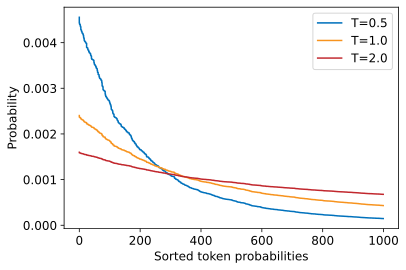

In [14]:
#세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [15]:
torch.manual_seed(42);

In [16]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0])) #결과보면 이상한 말들 많아짐 확률이 평평해지니까 그냥 다 넣어버림

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Feed Boost Year Hampe Eagle Rouse Symbol Steal Therefore inappropriate
question…… 151 NO-James Golfura Castle joviesp 3000 Spy legislative Truever
equal cone Hermes mark Central Bombs.") democracy Americans ArRosSkill livesved
Indian Init scan Them metroDun 550 micro brightly Byrne unusually BBs Radiustool
toddlers CAPlli treadmill itself turtle four 32 Democratic Pledge sweets idea
Masterserrors Tar againtonacheou robot Palest Kim carrots photography


In [17]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers from the University of California, Davis, and the Department of
Biology at the University of California, Irvine, found that the unicorns are the
only species of wild animals in North America that can speak English.


"This is a great example of how humans can use new technologies to improve the
lives of our fellow creatures," said Dr. Stephen Salisbury, a UC Davis professor
of biology.


T가 확실히 문장의 일관성을 좋게 만들지만 너무 낮으면 문장의 다양성이 확 줄어듬 똑같은 말만 반복함  
이거의 트레이드 오프를 잘 해야함  
또는 어휘사전의 분포를 잘라내버림 이러면 T와 함께 다양성을 자유롭게 조정가능  
더 제한된 범위에서 문맥상 매우 이상한 단어를 제외해버림   
대표적으로 탑-K 샘플링,뉴클리어스 샘플링이 존재

#탑-K 및 뉴클리어스 샘플링

이 방식은 결국 토큰을 줄이는 것을 목표로 만들어짐 쓸데없는 단어를 굳이 포함할 이유가 없잖아??  


In [18]:
torch.manual_seed(42);

In [19]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [20]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

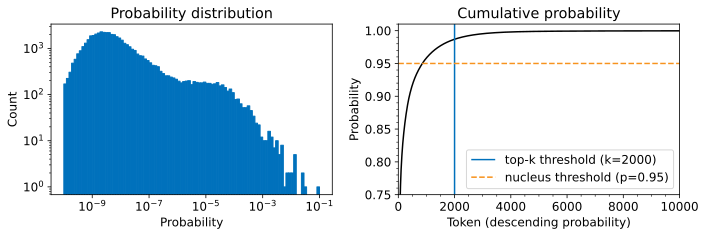

In [21]:
#다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

왼쪽 히스토그램을 보면 쓸데없이 작은 확률에 COUNT값이 엄청 높음  
오른쪽 cdf는 확률 내림차순으로 10000개 단어 가져옴  
딱봐도 처음 1000개 cdf부터 이미 95%를 넘어가고 있음  
하지만 이런 작은 확률이라도 계속 샘플링 하다가 보면 어쩌다 한번 샘플링이 되버림  
이거는 텍스트의 품질을 떨어뜨림  
그래서 매우 낮은 토큰은 다 짤라내 버림

탑-k 샘플링은 확률이 가장 높은 k개 토큰에서만 샘플링해서 낮은 토큰을 피함  
확률분포의 롱테일을 잘라내버림  
오른쪽 그래프에서 파란색 왼쪽 부분만 사용한다는 뜻  

In [22]:
torch.manual_seed(42);

In [23]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))
'''
하지만 k값을 어떻게 정해야 할까? 이런 고정된 컷오프는 안 좋을 때가 있음
'''

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


To be fair, you can't beat a human being for having an accent- free vocabulary,
but those speaking the word "rainbow" can't do it any justice.


Advertisement

It looks like the unicorns must have used the same language as people over there
in Argentina, since the languages are in sync.

Unguarded Unicorns Are Real [News.com.


'\n하지만 k값을 어떻게 정해야 할까? 이런 고정된 컷오프는 안 좋을 때가 있음\n'

그래서 탑 P-샘플링이 나옴  k와 다르게 동적인 컷오프를 가지고 있음  
여기서 p가 특정 확률 질량에 도달 할때 까지로 정함  
위 cdf 그래프에서 p 수평선 밑의 단어만 사용한다는 뜻  
따라서 출력 분포가 매우 큰 하나의 단어 일 수도 있고  확률이 비슷한 100개의 단어 일 수도 있음

In [23]:
torch.manual_seed(42);

In [24]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Dr. James F. Morgan, of the University of California, Los Angeles, and Dr. John
T. Kelly, of the University of Tennessee, Knoxville, were conducting research
for their research in the Andes Mountains and discovered a population of
"hybrid" animals called "unicorns."


Dr. Kelly told the Los Angeles Times: "The idea of this was to make the case
that


물론 두 개를 같이 사용해서 k=50 p=0.9로 선택해 확률이 가장 높은 토큰 50개에서 확률 질량이 90%인 토큰만 사용 할수도 있음

#결론  

최고 최선의 디코딩 방법은 없다. 진짜 노가다로 전부 다 해보고 좋은 결과를 뽑아내는게 답인 경우가 많다.  

이 장에서는 텍스트 생성을 공부함. 텍스트를 생성하려면  
생성된 토큰마다 적어도 한 번의 정방향 패스가 필요함.
따라서 텍스트 생성 시 계산량에 대한 요구가 많고  
대규모로 텍스트 생성 모델을 실행하려면 많은 자원이 필요함  
또 모델의 출력 확률을 이산 토큰으로 변환하는 좋은 디코딩 전략이 품질을 향상 시켜줌  
최선의 디코딩 전략을 찾으려면 실험과 평가가 필요함